In [1]:
## IMPORT NECESSARY PACKAGES #1

from pprint import pprint
# import pandasql as ps
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from zipfile import ZipFile
from io import BytesIO
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, HTML
# InteractiveShell.ast_node_interactivity = "all"
# CSS = """
# .output {
#     flex-direction: row;
# }
# """
# HTML('<style>{}</style>'.format(CSS))

sns.set()

In [2]:
## LOAD TORONTO DATASETS & DELETE WEIRD 

restaurants_df = pd.read_csv("american_restaurants.csv", sep='\t', encoding='utf-8')
reviews_df = pd.read_csv("american_reviews.csv", sep='\t', encoding='utf-8')

del(restaurants_df['Unnamed: 0'])
del(reviews_df['Unnamed: 0'])

restaurants_df = restaurants_df[restaurants_df['RestaurantsPriceRange2'] == 2]
reviews_df = reviews_df.loc[reviews_df['business_id'].isin(restaurants_df.business_id)]

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
restaurants_df.head()

,address,attributes,AcceptsInsurance,AgesAllowed,Alcohol,Ambience,BYOB,BYOBCorkage,BestNights,BikeParking,...,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,cuisine
0,2201 S Fort Apache Rd,NaN,NaN,NaN,full_bar,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,1,36.147496,-115.298066,Chicago Brewing Company,Westside,89117.0,446,3.5,NV,american
4,"7160 North Durango Dr, Ste 110",NaN,NaN,NaN,beer_and_wine,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,0,36.291436,-115.287016,Table 89,Centennial,89149.0,79,3.5,NV,american
5,6689 Las Vegas Blvd,NaN,NaN,NaN,beer_and_wine,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,...,1,36.067581,-115.174230,LV bar,Southeast,89119.0,22,4.5,NV,american
6,6683 Las Vegas Blvd S,NaN,NaN,NaN,full_bar,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,"{'monday': True, 'tuesday': False, 'friday': T...",True,...,1,36.066182,-115.175288,Miller's Ale House - Las Vegas,Southeast,89119.0,583,3.5,NV,american
7,"6430 N Durango Dr, Ste 110",NaN,NaN,NaN,full_bar,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,"{'monday': False, 'tuesday': False, 'friday': ...",True,...,1,36.277783,-115.286333,Distill - A Local Bar,Centennial,89149.0,203,4.0,NV,american


In [4]:
reviews_df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,jtQARsP6P-LbkyjbO1qNGg,1,2014-10-23,1.0,LZp4UX5zK3e-c5ZGSeo3kA,1.0,Terrible. Dry corn bread. Rib tips were all fa...,3.0,msQe1u7Z_XuqjGoqhB0J5g
2,faPVqws-x-5k2CQKDNtHxw,0,2015-03-25,2.0,QHueaxKHuBpbDOkWb0Cyfw,1.0,People please...the only good thing about this...,2.0,0AIj432MvowwghnpurtP-Q
5,3kdSl5mo9dWC4clrQjEDGg,0,2015-10-17,1.0,Bay72mIfR-yGKZf_S9xQeg,4.0,????????????????????????????????????\r\n?????7...,0.0,5oy_MM1skY1LvmdNNVVM5Q
6,f4x1YBxkLrZg652xt2KR5g,0,2015-10-17,0.0,YeRRSIod4aDvNDQKvbSWnA,3.0,????????????????????\r\n???Link Hotel???????\r...,0.0,5oy_MM1skY1LvmdNNVVM5Q
8,wuQDMDlqM17jQNo0lYQZ7g,0,2014-06-23,0.0,5kMnY9eUsskyknVszeqWQw,5.0,One of the best experiences I have had in Vega...,0.0,FHwl6kaKdD5-KAnfVb_pKQ


In [5]:
print('Number of categories listed',restaurants_df['city'].nunique())

restaurants_df['city'].head()

Number of categories listed 1


0    Las Vegas
4    Las Vegas
5    Las Vegas
6    Las Vegas
7    Las Vegas
Name: city, dtype: object

In [6]:
len(restaurants_df)

774

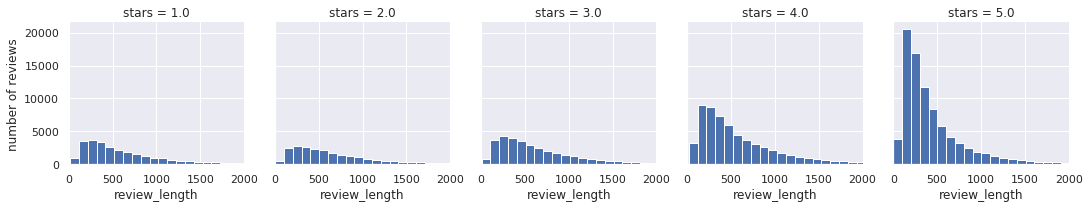

In [7]:
# check how the review lengths are distributed
reviews_df['review_length'] = reviews_df.text.map(len)

ax = sns.FacetGrid(data=reviews_df, col='stars', xlim=(0, 2000)).map(plt.hist, 'review_length', bins=50)

ax.axes[0][0].set(ylabel='number of reviews');

In [8]:
pos_reviews = reviews_df.text[reviews_df.stars>3.5].values
neg_reviews = reviews_df.text[reviews_df.stars<=3.5].values
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  147,567
Negative Reviews:  85,357


In [9]:
# additional stopwords
from sklearn.feature_extraction import text 
extra_words = ['ve', 'like', 'got', 'toronto', 'just', 
               'don', 'really', 'said', 'told', 'ok',
               'came', 'went', 'did', 'didn', 'good']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)

In [10]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 20000
random_neg = np.random.choice(neg_reviews, size=num_reviews)
random_pos = np.random.choice(pos_reviews, size=num_reviews)

dicty = {'pizzas':'pizza', 'burgers':'burger', 'ordered':'order',
         'prices':'price', 'topping':'toppings'}
def replace_words(text, dicty):
    '''Returns text with word substitutions made according
       to the passed `dicty` dictionary'''
    for i,j in dicty.items():
        text = text.replace(i,j)
    return text

random_neg = [replace_words(w, dicty) for w in random_neg]
random_pos = [replace_words(w, dicty) for w in random_pos]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(random_neg)
pos_vectors = tfidf_pos.fit_transform(random_pos)

CPU times: user 1.99 s, sys: 53.4 ms, total: 2.04 s
Wall time: 2.14 s


In [11]:
# Store TFIDF vectors in a Pandas DataFrame to investigate further
neg_df = pd.DataFrame(neg_vectors.todense(), columns=[tfidf_neg.get_feature_names()])
pos_df = pd.DataFrame(pos_vectors.todense(), columns=[tfidf_pos.get_feature_names()])

# get mean for each column (word): highest means are most important words
col_means_neg = {}
for col in neg_df:
    col_means_neg[col] = neg_df[col].mean()

col_means_pos = {}
for col in pos_df:
    col_means_pos[col] = pos_df[col].mean()

In [12]:
no_top_words = 10

print('Top %d words in POSITIVE reviews:' %no_top_words, end='')
print(sorted(col_means_pos, key=col_means_pos.get, reverse=True)[:no_top_words])

print('Top %d words in NEGATIVE reviews:' %no_top_words, end='')
print(sorted(col_means_neg, key=col_means_neg.get, reverse=True)[:no_top_words])

Top 10 words in POSITIVE reviews:[('great',), ('place',), ('service',), ('burger',), ('time',), ('order',), ('vegas',), ('amazing',), ('delicious',), ('chicken',)]
Top 10 words in NEGATIVE reviews:[('order',), ('service',), ('place',), ('burger',), ('time',), ('great',), ('chicken',), ('minutes',), ('fries',), ('restaurant',)]


In [13]:
# delete dataframes to save memory
del neg_df
del pos_df

In [14]:
# LSA
from gensim import corpora, models, similarities, matutils

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants terms by docs instead of docs by terms
tfidf_pos_corpus = matutils.Sparse2Corpus(pos_vectors.transpose())
tfidf_neg_corpus = matutils.Sparse2Corpus(neg_vectors.transpose())

# Row indices
id2word_pos = dict((v,k) for k,v in tfidf_pos.vocabulary_.items())
id2word_neg = dict((v,k) for k,v in tfidf_neg.vocabulary_.items())

# This is a hack for Python 3!
id2word_pos = corpora.Dictionary.from_corpus(tfidf_pos_corpus, id2word=id2word_pos)
id2word_neg = corpora.Dictionary.from_corpus(tfidf_neg_corpus, id2word=id2word_neg)

In [18]:
# create LSA model
num_topics = 7
lsi_pos = models.LsiModel(tfidf_pos_corpus, id2word=id2word_pos, num_topics=num_topics)
lsi_neg = models.LsiModel(tfidf_neg_corpus, id2word=id2word_neg, num_topics=num_topics)

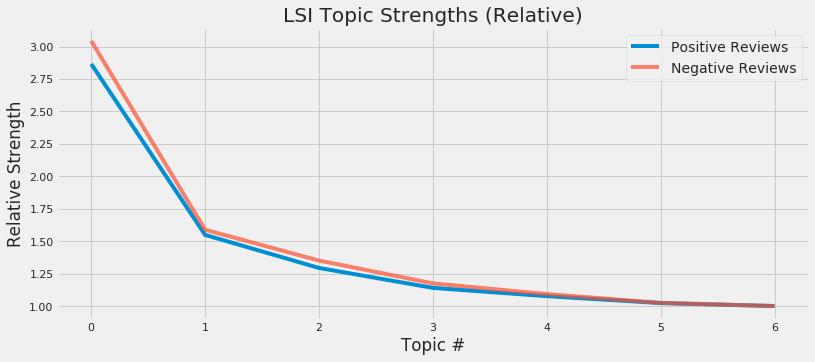

In [19]:
# elbow plot
singular_values_pos = lsi_pos.projection.s.tolist()
singular_values_pos_rel = [sv/singular_values_pos[-1] for sv in singular_values_pos]
singular_values_neg = lsi_neg.projection.s.tolist()
singular_values_neg_rel = [sv/singular_values_neg[-1] for sv in singular_values_neg]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.plot(range(len(singular_values_pos)), singular_values_pos_rel, label='Positive Reviews', alpha=1.0)
plt.plot(range(len(singular_values_neg)), singular_values_neg_rel, label='Negative Reviews', alpha=0.7)
plt.xticks(range(len(singular_values_pos)), range(len(singular_values_pos)))
plt.xlabel('Topic #')
plt.ylabel('Relative Strength')
plt.title('LSI Topic Strengths (Relative)')
plt.legend(loc=0, fontsize='medium');

In [20]:
topics_to_print = 5

In [21]:
# look at top positive topics
print('Top %d topics for POSITIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_pos.show_topics()[0:topics_to_print])

Top 5 topics for POSITIVE reviews
---------------------------------
[(0,
  '0.281*"great" + 0.229*"place" + 0.224*"burger" + 0.196*"service" + '
  '0.145*"order" + 0.144*"time" + 0.137*"vegas" + 0.129*"amazing" + '
  '0.127*"breakfast" + 0.126*"chicken"'),
 (1,
  '-0.783*"burger" + -0.294*"fries" + 0.223*"great" + 0.173*"breakfast" + '
  '0.127*"service" + 0.103*"place" + -0.095*"truffle" + -0.093*"shake" + '
  '-0.085*"cheese" + 0.078*"friendly"'),
 (2,
  '-0.567*"great" + 0.289*"chicken" + -0.251*"service" + -0.215*"burger" + '
  '0.184*"order" + 0.164*"fried" + 0.130*"waffles" + 0.123*"breakfast" + '
  '-0.116*"atmosphere" + 0.116*"eggs"'),
 (3,
  '0.602*"breakfast" + 0.208*"pancakes" + 0.188*"burger" + -0.176*"bar" + '
  '-0.164*"happy" + 0.159*"eggs" + -0.153*"hour" + -0.151*"chicken" + '
  '0.146*"best" + 0.125*"vegas"'),
 (4,
  '0.425*"chicken" + 0.371*"great" + -0.332*"place" + -0.284*"love" + '
  '0.241*"service" + 0.202*"fried" + 0.191*"waffles" + -0.136*"bar" + '
  '-0.123*"

In [22]:

# look at top negative topics
print('Top %d topics for NEGATIVE reviews' %(topics_to_print))
print('-'*33)
pprint(lsi_neg.show_topics()[0:topics_to_print])

Top 5 topics for NEGATIVE reviews
---------------------------------
[(0,
  '0.221*"order" + 0.215*"burger" + 0.187*"place" + 0.187*"service" + '
  '0.150*"time" + 0.126*"minutes" + 0.116*"great" + 0.114*"fries" + '
  '0.110*"chicken" + 0.106*"table"'),
 (1,
  '0.774*"burger" + 0.280*"fries" + -0.153*"minutes" + 0.108*"cheese" + '
  '-0.106*"service" + -0.102*"table" + -0.090*"server" + -0.087*"time" + '
  '0.083*"shake" + -0.077*"took"'),
 (2,
  '0.333*"burger" + 0.287*"minutes" + -0.240*"chicken" + -0.214*"buffet" + '
  '-0.205*"breakfast" + 0.147*"waited" + 0.142*"table" + 0.133*"took" + '
  '0.125*"order" + -0.123*"eggs"'),
 (3,
  '-0.418*"chicken" + -0.328*"order" + 0.288*"buffet" + 0.188*"place" + '
  '0.166*"bar" + 0.150*"service" + 0.143*"price" + 0.139*"vegas" + '
  '-0.129*"fried" + -0.129*"salad"'),
 (4,
  '-0.485*"breakfast" + -0.307*"eggs" + 0.303*"chicken" + 0.229*"bar" + '
  '-0.165*"pancakes" + -0.165*"coffee" + 0.160*"salad" + -0.148*"toast" + '
  '-0.146*"hash" + -0.13

In [23]:

%%time
# negative values in LSA topics are annoying
# let's see if we can fix that with NMF
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

CPU times: user 4.85 s, sys: 4.87 s, total: 9.72 s
Wall time: 3.77 s


In [24]:
def display_topics(model, feature_names, num_topics, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx < num_topics:
            print("{:11}".format("Topic %d:" %(topic_idx)), end='')
            print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                             for i in topic.argsort()[:-no_top_words-1:-1]]))

no_topics = num_topics
no_top_words = 6

print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.097*order, 0.946*time, 0.797*menu, 0.637*nice, 0.637*restaurant, 0.602*bar
Topic 1:   3.141*burger, 1.165*fries, 0.378*truffle, 0.354*shake, 0.331*cheese, 0.258*best
Topic 2:   2.839*great, 1.482*service, 0.481*atmosphere, 0.422*excellent, 0.405*awesome, 0.395*friendly
Topic 3:   2.222*breakfast, 0.854*pancakes, 0.684*eggs, 0.438*toast, 0.429*coffee, 0.370*hash
Topic 4:   2.320*chicken, 1.091*fried, 0.982*waffles, 0.298*bacon, 0.292*cheese, 0.274*sage
Topic 5:   2.334*place, 1.486*love, 0.951*amazing, 0.781*vegas, 0.532*best, 0.521*staff

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.517*minutes, 1.344*order, 1.045*table, 0.929*took, 0.906*server, 0.843*time
Topic 1:   3.081*burger, 1.086*fries, 0.341*cheese, 0.324*shake, 0.244*better, 0.233*medium
Topic 2:   1.481*place, 0.946*service, 0.893*great, 0.812*bar, 0.480*pretty, 0.476*nice
Topic 3:   1.

In [25]:
# look at a random positive review
review_num = np.random.randint(0, high=len(random_pos))
print(review_num)
print(random_pos[review_num])


352
Wow, this place meets all the expectations the reviews suggest. Food was fantastic and the portions huge.  The wait staff looked like a local Harley club and were some of the most considerate and attentive people I met while visiting Las Vegas. I wish I had discovered this place my first day rather than just before my flight home. I will return on my next visit, which I hope is soon!


In [27]:
# look at a random negative review
review_num = np.random.randint(0, high=len(random_neg))
print(review_num)
print(random_neg[review_num])


8509
Staff was not trained on food at all. Pork was dry, the sauce has so much cinnamon in, it is way over powering.  Ribs were well executed which got the second star. , but the rub is still very cinnamon stong

Now on to the price Holy cow,  this give Lucille s a run for thier greedy money.  24 dollars for a 2 meat combo. 

Bbq is better done off the strip.


In [28]:

# compute cosine similarities of this review with all other reviews in the new space
import sklearn.metrics.pairwise as smp

cosines = {}
for ind, review in enumerate(W_pos):
    similarity = smp.cosine_similarity(W_pos[review_num].reshape(1,-1), review.reshape(1,-1))
    cosines[ind] = similarity[0][0]

In [29]:

# get top 3 matching reviews
for n in sorted(cosines, key=cosines.get, reverse=True)[1:4]:
    print('-'*50)
    print('>> Similarity {:.3f}'.format(cosines[n]))
    print(random_pos[n])
print('-'*50)

--------------------------------------------------
>> Similarity 0.976
Just had lunch at Citizens.  We had the mahi mahi fish tacos and the chicken quesadilla - both were very good.  The tacos has big filets of fish , rather than the usual chunks.  Fish was delicious as well as the entire taco.  Bustling, but relaxed atmosphere, good service even though the place was busy.  I also tried the Ginger Snap juice smoothie - was very good.  There was a choice of 6-8 juice smoothies.  This place offers comfort food, but plenty of healthy options too.  We saw a few burger come past - they looked great.
--------------------------------------------------
>> Similarity 0.976
Very good place! Some of the best gravy you will find outside grandmas kitchen. You can bank on that.

Also the best Mac n Cheese I've ever had. If only it had Lobster as an option! 

The meatballs are excellent. The Lasagana was excellent. The Caprese was excellent. The calamari was very good.

We will definitely be back.

O

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a vectorizer object to generate term document counts
cv_pos = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

cv_neg = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# Get random subset of reviews
np.random.seed(38)
num_reviews = 15000
cv_random_neg = np.random.choice(neg_reviews, size=num_reviews)
cv_random_pos = np.random.choice(pos_reviews, size=num_reviews)

# replace words from defined dictionary 'dicty'
cv_random_neg = [replace_words(w, dicty) for w in cv_random_neg]
cv_random_pos = [replace_words(w, dicty) for w in cv_random_pos]

# Get the cv vectors
cv_neg_vectors = cv_neg.fit_transform(cv_random_neg).transpose()
cv_pos_vectors = cv_pos.fit_transform(cv_random_pos).transpose()

In [31]:
# Convert sparse matrix of counts to a gensim corpus
corpus_neg = matutils.Sparse2Corpus(cv_neg_vectors)
corpus_pos = matutils.Sparse2Corpus(cv_pos_vectors)

# save a mapping (dict) of row id to word (token) for later use by gensim 
id2word_cv_pos = dict((v, k) for k, v in cv_pos.vocabulary_.items())
id2word_cv_neg = dict((v, k) for k, v in cv_neg.vocabulary_.items())

In [32]:
%%time
# create lda multicore model
lda_pos = models.ldamulticore.LdaMulticore(corpus=corpus_pos, num_topics=5, 
                                           id2word=id2word_cv_pos, passes=10, workers=15)
lda_neg = models.ldamulticore.LdaMulticore(corpus=corpus_neg, num_topics=5, 
                                           id2word=id2word_cv_neg, passes=10, workers=15)

CPU times: user 2min 38s, sys: 30.9 s, total: 3min 9s
Wall time: 5min 46s


In [33]:
print('Top topics + words for POSITIVE reviews')
print('-'*39)
pprint(lda_pos.print_topics(num_words=7))

print('\nTop topics + words for NEGATIVE reviews')
print('-'*39)
pprint(lda_neg.print_topics(num_words=7))

Top topics + words for POSITIVE reviews
---------------------------------------
[(0,
  '0.042*"burger" + 0.017*"fries" + 0.012*"place" + 0.011*"great" + '
  '0.011*"time" + 0.010*"service" + 0.009*"order"'),
 (1,
  '0.032*"great" + 0.020*"service" + 0.019*"place" + 0.011*"chicken" + '
  '0.010*"amazing" + 0.010*"delicious" + 0.009*"order"'),
 (2,
  '0.012*"chicken" + 0.011*"order" + 0.009*"cheese" + 0.009*"sauce" + '
  '0.007*"delicious" + 0.006*"fries" + 0.006*"burger"'),
 (3,
  '0.017*"place" + 0.015*"great" + 0.010*"time" + 0.010*"vegas" + '
  '0.010*"service" + 0.008*"love" + 0.007*"burger"'),
 (4,
  '0.019*"breakfast" + 0.016*"place" + 0.011*"great" + 0.010*"order" + '
  '0.009*"eggs" + 0.008*"vegas" + 0.008*"time"')]

Top topics + words for NEGATIVE reviews
---------------------------------------
[(0,
  '0.012*"breakfast" + 0.011*"place" + 0.008*"service" + 0.008*"buffet" + '
  '0.008*"price" + 0.008*"vegas" + 0.008*"order"'),
 (1,
  '0.012*"menu" + 0.011*"service" + 0.011*"order

## Continuing with NMF

In [34]:
# let's remind ourselves of the POSITIVE topics
print('Top topics + words for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

Top topics + words for POSITIVE reviews
---------------------------------------
Topic 0:   1.097*order, 0.946*time, 0.797*menu, 0.637*nice, 0.637*restaurant, 0.602*bar
Topic 1:   3.141*burger, 1.165*fries, 0.378*truffle, 0.354*shake, 0.331*cheese, 0.258*best
Topic 2:   2.839*great, 1.482*service, 0.481*atmosphere, 0.422*excellent, 0.405*awesome, 0.395*friendly
Topic 3:   2.222*breakfast, 0.854*pancakes, 0.684*eggs, 0.438*toast, 0.429*coffee, 0.370*hash
Topic 4:   2.320*chicken, 1.091*fried, 0.982*waffles, 0.298*bacon, 0.292*cheese, 0.274*sage
Topic 5:   2.334*place, 1.486*love, 0.951*amazing, 0.781*vegas, 0.532*best, 0.521*staff


In [35]:
# we can investigate a random positive review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_pos))
print('Positive Review #%d' %review_num)
print('-'*25)
print(random_pos[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_pos[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Positive Review #17123
-------------------------
I've been here about 4-5 times and no one ever told me about the rewards card.. The normal girl that rings me out isn't very friendly nor does she smile much which is a huge turn off in any customer service establishment.
However! What saved my opinion on this place was Dakota! Absolutely incredible guy awesome personality and signed me up for the loyalty program and was very apologetic that no one else mentioned it.
I'm a manager and honestly this is what I strive to have my employees be like.
Great food and smoothies plus it's a healthy place to eat which I enjoy!
-------------------------
Topic 5: 0.0378
Topic 2: 0.0267
Topic 0: 0.0053
Topic 1: 0.0022
Topic 3: 0.0000
Topic 4: 0.0000


In [36]:
print('Top topics + words for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Top topics + words for NEGATIVE reviews
---------------------------------------
Topic 0:   1.517*minutes, 1.344*order, 1.045*table, 0.929*took, 0.906*server, 0.843*time
Topic 1:   3.081*burger, 1.086*fries, 0.341*cheese, 0.324*shake, 0.244*better, 0.233*medium
Topic 2:   1.481*place, 0.946*service, 0.893*great, 0.812*bar, 0.480*pretty, 0.476*nice
Topic 3:   1.776*chicken, 0.814*salad, 0.719*order, 0.613*cheese, 0.600*sandwich, 0.567*fried
Topic 4:   1.789*breakfast, 1.188*eggs, 0.673*pancakes, 0.610*coffee, 0.600*hash, 0.593*toast
Topic 5:   2.078*buffet, 0.453*vegas, 0.419*price, 0.389*buffets, 0.349*better, 0.344*selection


In [37]:
# now investigate a random negative review and see how it's distributed across those topics
review_num = np.random.randint(0, high=len(random_neg))
print('Negative Review #%d' %review_num)
print('-'*25)
print(random_neg[review_num])
print('-'*25)
topic_dict = {}
for ind, w in enumerate(W_neg[review_num]):
    topic_dict[ind] = w
for k in sorted(topic_dict, key=topic_dict.get, reverse=True):
     print('Topic {}: {:.4f}'.format(k, topic_dict[k]))

Negative Review #18063
-------------------------
Dear Lord, stay away. I'm reminded of the commissary in college eating here. Granted, the dishes and variety is far superior to what we had in college. The quality is not up to standard. The lunch price of $19.99 is fair for a buffet but, the overall quality of the dishes still doesn't support it. 

The Luxor could spend a bit more effort in delivering a higher quality experience
-------------------------
Topic 5: 0.0768
Topic 2: 0.0068
Topic 3: 0.0020
Topic 1: 0.0015
Topic 0: 0.0000
Topic 4: 0.0000


## Topic Modeling All Reviews 
At this point, we can see that our topics are relatively interpretable and match along with the reviews they're trying to categorize. Let's proceed with topic modeling all reviews and businesses using NMF.

In [38]:
print('Postive Reviews:  {:,}'.format(len(pos_reviews)))
print('Negative Reviews:  {:,}'.format(len(neg_reviews)))

Postive Reviews:  147,567
Negative Reviews:  85,357


In [39]:
%%time
# Create a vectorizer object to generate term document counts
tfidf_pos = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

tfidf_neg = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5, 
                        ngram_range=(1,1), token_pattern='[a-z][a-z]+')

# replace words with defined dictionary 'dicty'
pos_reviews = [replace_words(w, dicty) for w in pos_reviews]
neg_reviews = [replace_words(w, dicty) for w in neg_reviews]

# Get the vectors
neg_vectors = tfidf_neg.fit_transform(neg_reviews)
pos_vectors = tfidf_pos.fit_transform(pos_reviews)

CPU times: user 12.7 s, sys: 683 ms, total: 13.4 s
Wall time: 50.1 s


In [40]:
%%time
# NMF for all reviews
from sklearn.decomposition import NMF

# change num_topics
num_topics = 6

nmf_pos = NMF(n_components=num_topics)
W_pos = nmf_pos.fit_transform(pos_vectors)
H_pos = nmf_pos.components_

nmf_neg = NMF(n_components=num_topics)
W_neg = nmf_neg.fit_transform(neg_vectors)
H_neg = nmf_neg.components_

CPU times: user 22.9 s, sys: 22 s, total: 44.9 s
Wall time: 17.1 s


In [41]:
no_topics = num_topics
no_top_words = 6

print('Topics for POSITIVE reviews')
print('-'*39)
display_topics(nmf_pos, tfidf_pos.get_feature_names(), no_topics, no_top_words)

print('\nTopics for NEGATIVE reviews')
print('-'*39)
display_topics(nmf_neg, tfidf_neg.get_feature_names(), no_topics, no_top_words)

Topics for POSITIVE reviews
---------------------------------------
Topic 0:   1.770*order, 1.402*time, 1.259*menu, 1.122*nice, 1.053*restaurant, 1.039*bar
Topic 1:   5.063*burger, 1.902*fries, 0.595*shake, 0.578*truffle, 0.539*cheese, 0.429*onion
Topic 2:   4.700*great, 2.268*service, 0.766*atmosphere, 0.632*awesome, 0.622*excellent, 0.501*friendly
Topic 3:   3.541*breakfast, 1.441*pancakes, 1.180*eggs, 0.787*toast, 0.660*coffee, 0.630*hash
Topic 4:   3.844*chicken, 1.750*fried, 1.632*waffles, 0.485*bacon, 0.472*salad, 0.455*cheese
Topic 5:   3.549*place, 2.208*love, 1.840*amazing, 1.427*vegas, 1.275*best, 1.037*staff

Topics for NEGATIVE reviews
---------------------------------------
Topic 0:   2.159*minutes, 1.883*order, 1.455*table, 1.350*took, 1.314*server, 1.177*wait
Topic 1:   4.353*burger, 1.590*fries, 0.448*shake, 0.438*cheese, 0.336*medium, 0.325*onion
Topic 2:   2.095*place, 1.470*service, 1.244*great, 1.163*bar, 0.687*nice, 0.668*bad
Topic 3:   2.496*chicken, 1.080*salad, 

In [42]:
# create topic dictionaries to summarize the topic meanings
pos_topics = {0:'menu/experience', 1:'burger/fries', 2:'service/atmosphere', 
              3:'breakfast/pancakes', 4:'chicken/waffles', 5:'location/atmosphere'}

neg_topics = {0:'wait/table', 1:'burger/fries', 2:'bad_service', 
              3:'chicken/salad', 4:'breakfast/eggs', 5:'buffet/price'}

## Adding Topic Weights to Pandas DataFrame

In [44]:
# we create dataframes for positive & negative reviews that we can
# later add topic information to
df_pos = reviews_df[['business_id', 'stars', 'text', 'review_length']][reviews_df.stars>3].reset_index()
df_neg = reviews_df[['business_id', 'stars', 'text', 'review_length']][reviews_df.stars<3].reset_index()
df_pos.drop(labels='index', axis=1, inplace=True)
df_neg.drop(labels='index', axis=1, inplace=True)

In [45]:
print('Topic weights : ', W_pos[0])
print('Sum of weights: ', W_pos[0].sum())

Topic weights :  [0. 0. 0. 0. 0. 0.]
Sum of weights:  0.0


In [46]:
from sklearn.preprocessing import normalize
print('Normalized Topic weights : ', normalize(W_pos[0].reshape(1,-1), norm='l1'))
print('Sum of normalized weights: ', normalize(W_pos[0].reshape(1,-1), norm='l1').sum())

Normalized Topic weights :  [[0. 0. 0. 0. 0. 0.]]
Sum of normalized weights:  0.0


In [47]:
# add normalized topic weights to each review
df_pos = pd.concat([df_pos, pd.DataFrame(normalize(W_pos, norm='l1'))], axis=1)
df_neg = pd.concat([df_neg, pd.DataFrame(normalize(W_neg, norm='l1'))], axis=1)

In [48]:
# peek into a dataframe to ensure it worked right
df_neg.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,jtQARsP6P-LbkyjbO1qNGg,1.0,Terrible. Dry corn bread. Rib tips were all fa...,156.0,0.000000,0.023054,0.000867,0.751708,0.000000,0.224370
1,faPVqws-x-5k2CQKDNtHxw,1.0,People please...the only good thing about this...,622.0,0.253096,0.013696,0.615945,0.117262,0.000000,0.000000
2,ZtsnwjxjzMUI6tDZNrJUeA,1.0,If there was an option to give this place nega...,734.0,0.000000,0.000000,0.304793,0.000000,0.101528,0.593679
3,NvKNe9DnQavC9GstglcBJQ,1.0,My friends and I went into Grand Lux Cafe at t...,580.0,0.204687,0.061922,0.377754,0.276894,0.078744,0.000000
4,jdAdf7keZac1idbgNKG2pw,1.0,Went with my daughter tonight and was refused ...,500.0,0.000000,0.965198,0.034802,0.000000,0.000000,0.000000


In [49]:
# group by business_id and apply mean/count functions to columns
df_pos_bsns = df_pos.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()
df_neg_bsns = df_neg.groupby('business_id').agg({'stars':'mean', 'text':'count',
                                                 'review_length':'mean',0:'mean', 
                                                 1:'mean', 2:'mean', 3:'mean',
                                                 4:'mean', 5:'mean'}).reset_index()

In [50]:
df_pos_bsns.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,-CQokjildrY7UZezXCdEBw,4.875000,40,743.800000,0.317745,0.103765,0.176195,0.008446,0.142640,0.251209
1,-JfncbVURtvuzBbof40o1w,4.176471,34,556.735294,0.310097,0.054310,0.112984,0.281021,0.143596,0.097991
2,-OEIW0dO96-492qa_luxaw,4.557143,210,669.052381,0.339588,0.072047,0.272646,0.016357,0.048552,0.250810
3,-PGsEXB6DFTVKa1eDOlzWA,4.660550,109,459.532110,0.217718,0.029131,0.268024,0.218575,0.080800,0.185753
4,-SGZcGqnsp_uRIjKP2RGZg,4.666667,6,343.666667,0.332862,0.000000,0.251487,0.192183,0.012526,0.210942


In [51]:
df_neg_bsns.head()

,business_id,stars,text,review_length,0,1,2,3,4,5
0,-CQokjildrY7UZezXCdEBw,2.000000,1,1657.000000,0.111447,0.285122,0.393136,0.000000,0.000000,0.210296
1,-JfncbVURtvuzBbof40o1w,1.430769,65,642.630769,0.172101,0.128016,0.316126,0.162161,0.115720,0.105877
2,-OEIW0dO96-492qa_luxaw,1.363636,33,841.121212,0.228583,0.107326,0.225116,0.227096,0.146760,0.065119
3,-PGsEXB6DFTVKa1eDOlzWA,1.400000,65,940.276923,0.165311,0.094164,0.321069,0.176041,0.137894,0.105520
4,-SGZcGqnsp_uRIjKP2RGZg,1.000000,3,632.000000,0.082803,0.000000,0.207097,0.343421,0.292640,0.074038


## Adding in Business Information 

In [52]:
# merge business name/city with topic data
df_pos_tot = df_pos_bsns.merge(restaurants_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars_y', 0, 1, 2, 3, 4, 5]]

df_neg_tot = df_neg_bsns.merge(restaurants_df[['business_id', 'name', 'city', 'stars']], left_on='business_id', 
                               right_on='business_id')[['business_id', 'name', 'city', 'stars_y', 0, 1, 2, 3, 4, 5]]

In [53]:
# peek into business/topic distributions
df_neg_tot.head(10)

,business_id,name,city,stars_y,0,1,2,3,4,5
0,-CQokjildrY7UZezXCdEBw,Toddy Shop,Las Vegas,5.0,0.111447,0.285122,0.393136,0.000000,0.000000,0.210296
1,-JfncbVURtvuzBbof40o1w,The Cafe at Monte Carlo,Las Vegas,2.5,0.172101,0.128016,0.316126,0.162161,0.115720,0.105877
2,-OEIW0dO96-492qa_luxaw,Aces & Ales,Las Vegas,4.0,0.228583,0.107326,0.225116,0.227096,0.146760,0.065119
3,-PGsEXB6DFTVKa1eDOlzWA,Black Bear Diner,Las Vegas,3.5,0.165311,0.094164,0.321069,0.176041,0.137894,0.105520
4,-SGZcGqnsp_uRIjKP2RGZg,Ranch House Grille,Las Vegas,3.5,0.082803,0.000000,0.207097,0.343421,0.292640,0.074038
5,-U7tvCtaraTQ9b0zBhpBMA,MGM Grand Buffet,Las Vegas,2.5,0.208903,0.087847,0.314483,0.166045,0.109821,0.112901
6,-UtYWvCnUppcSaC_u1pTYQ,Kopper Keg Restaurant & Lounge,Las Vegas,4.0,0.000000,0.235492,0.000000,0.677922,0.086586,0.000000
7,-Ylpy3VyRWwubf9dysuwjQ,The Cheesecake Factory,Las Vegas,3.5,0.198620,0.100755,0.283538,0.228635,0.114589,0.073863
8,-a857YYdjzgOdOjFFRsRXQ,Beer Park,Las Vegas,3.5,0.250286,0.086495,0.295853,0.169394,0.101435,0.096537
9,-kbPPBNsIPDfMfgUGO7QhA,Kopper Keg South,Las Vegas,4.0,0.178385,0.050138,0.621796,0.061762,0.048663,0.039256


In [54]:
scores = df_neg_bsns[df_neg_bsns.business_id == '-UtYWvCnUppcSaC_u1pTYQ'].iloc[:,-6:].values
print(restaurants_df[restaurants_df.business_id == '-UtYWvCnUppcSaC_u1pTYQ']['name'].values[0] + ' - Positive Reviews')
print('-'*36)
for n in neg_topics:
    print('Topic {}: {:18} > {:.4f}'.format(n, neg_topics[n], scores[0][n]))

Kopper Keg Restaurant & Lounge - Positive Reviews
------------------------------------
Topic 0: wait/table         > 0.0000
Topic 1: burger/fries       > 0.2355
Topic 2: bad_service        > 0.0000
Topic 3: chicken/salad      > 0.6779
Topic 4: breakfast/eggs     > 0.0866
Topic 5: buffet/price       > 0.0000


In [55]:
%%time
# write to CSV
df_pos_tot.to_csv('pos_bsns.csv')
df_neg_tot.to_csv('neg_bsns.csv')
df_pos.to_csv('pos_reviews.csv')
df_neg.to_csv('neg_reviews.csv')

CPU times: user 3.52 s, sys: 77.1 ms, total: 3.6 s
Wall time: 4 s
